## Apple Model
This notebook is the seperate implementation on the apple stocks data. It is made in following manner:
1. Import Libraries
2. Read and process the data
    - Normalize the data
    - Polymerize data
    - Split into training and testing
    - change dimentions
3. Implement the Baseline model
    - Make model
    - Train model
    - Predict on test data
    - Calculate score and make prediction graph
3. Make Final model
    - Make and compile model 
    - Train model using Simple training
    - Predict on test data
    - Calculate score and make prediction graph
    - Train model using Framed training
    - Predict on test data
    - Calculate score and make prediction graph

## Import lib

In [1]:
# get all the imports
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras import optimizers

import tensorflow as tf

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Using TensorFlow backend.
/Users/batman/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Read the datafile

change the directory if needed

In [ ]:
cd Data

#### Read the file using pandas and preprocess it

In [4]:
# read the csv file
apple=pd.read_csv('AppleFinalData.csv')
# process the colums of the file
apple=apple.rename(columns={'Adj Close':'Price'})   # reaname the column
apple=apple.drop('Close',axis=1)                    # remove the unused column
apple['Month']=int                                  # add a blank month column in the data field

# add the data into the month column, it will take time
for i in range(len(apple)):
  apple['Month'][i]=int(apple['Date'][i].split('-')[1])

# arrange the final sequence of column
apple=apple[['Open', 'High', 'Low', 'compound', 'neg', 'neu', 'pos','Month','Date','Price']]   
apple.columns   # check the finla output

/Users/batman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Index(['Open', 'High', 'Low', 'compound', 'neg', 'neu', 'pos', 'Month', 'Date',
       'Price'],
      dtype='object')

#### Split the data into news and stock

**only the Opening price of the stock is taken.

In [6]:
stock=apple.iloc[:,:1].values
news=apple.iloc[0:,3:7].values

#### Normalize the stock data

In [7]:
stock=(stock-np.min(stock))/(np.max(stock)-np.min(stock))

#### Polymerise Stock data

since we are using only one data coloumn form stock

In [8]:
# # to make polynomial feature set
poly=PolynomialFeatures(degree=2)
stock=poly.fit_transform(stock)

#### Split the data into train and test data

In [16]:
train_x= np.hstack([stock[:2033],news[:2033]])
train_y= apple.iloc[:2033,9:].values

test_x= np.hstack([stock[2033:],news[2033:]])
test_y= apple.iloc[2033:,9:].values

#### Reshape the input feature set for LSTM

In [17]:
# reshape the data acording to the lstm
train_x=train_x.reshape(train_x.shape[:1][0],1,6)
test_x=test_x.reshape(484,1,6)

## Baseline Model
Made on the basis of assumption made on data analysis

In [74]:
# make model
model=Sequential()

# layer 1
model.add(LSTM(128,input_shape=(1,train_x.shape[2:][0]),activation='relu', return_sequences=True ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 2
model.add(LSTM(128, return_sequences=True ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 3
model.add(LSTM(128, activation='relu',return_sequences=False ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 4
model.add(Dense(100,activation='relu' ))
model.add(Dropout(0.3))
model.add(BatchNormalization())
# layer 5
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 6
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# final output in 1
model.add(Dense(1))

# make optimiser
opt=keras.optimizers.RMSprop(lr=0.001,rho=0.9, decay=0.0)
# compile the model
model.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])

# to log the data for tensorboard
time=datetime.now()
tbCallBack = keras.callbacks.TensorBoard(log_dir='/log/apple_baseline'+str(time), write_graph=True)

# for the model checkpoints
filepath="Weights/apple_baseline_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint,tbCallBack]

In [75]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 1, 128)            69120     
_________________________________________________________________
dropout_41 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 1, 128)            512       
_________________________________________________________________
lstm_21 (LSTM)               (None, 1, 128)            131584    
_________________________________________________________________
dropout_42 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 1, 128)            512       
_________________________________________________________________
lstm_22 (LSTM)               (None, 128)               131584    
__________

#### Train the model

In [65]:
model.fit(
        train_x
        ,train_y
        , epochs=30
        ,batch_size=10
    
        ,verbose=1
        ,validation_split=0.1 
        ,callbacks=callbacks_list
        )

Train on 1829 samples, validate on 204 samples
Epoch 1/30
1829/1829 [==============================] - 11s 6ms/step - loss: 2046.4759 - acc: 0.0000e+00 - val_loss: 9341.1002 - val_acc: 0.0000e+00
Epoch 2/30
1829/1829 [==============================] - 5s 3ms/step - loss: 1464.3435 - acc: 0.0000e+00 - val_loss: 6923.3049 - val_acc: 0.0000e+00
Epoch 3/30
1829/1829 [==============================] - 3s 2ms/step - loss: 959.2775 - acc: 0.0000e+00 - val_loss: 2851.4726 - val_acc: 0.0000e+00
Epoch 4/30
1829/1829 [==============================] - 4s 2ms/step - loss: 480.7720 - acc: 0.0000e+00 - val_loss: 362.4776 - val_acc: 0.0000e+00
Epoch 5/30
1829/1829 [==============================] - 5s 3ms/step - loss: 184.6721 - acc: 0.0000e+00 - val_loss: 1245.7859 - val_acc: 0.0000e+00
Epoch 6/30
1829/1829 [==============================] - 4s 2ms/step - loss: 130.7835 - acc: 0.0000e+00 - val_loss: 1003.0983 - val_acc: 0.0000e+00
Epoch 7/30
1829/1829 [==============================] - 4s 2ms/step -

Epoch 30/30
1829/1829 [==============================] - 4s 2ms/step - loss: 90.6759 - acc: 0.0000e+00 - val_loss: 744.9385 - val_acc: 0.0000e+00


#### Predict the data using the model

In [70]:
predict=model.predict(test_x)

Plot the data that is predicted by model

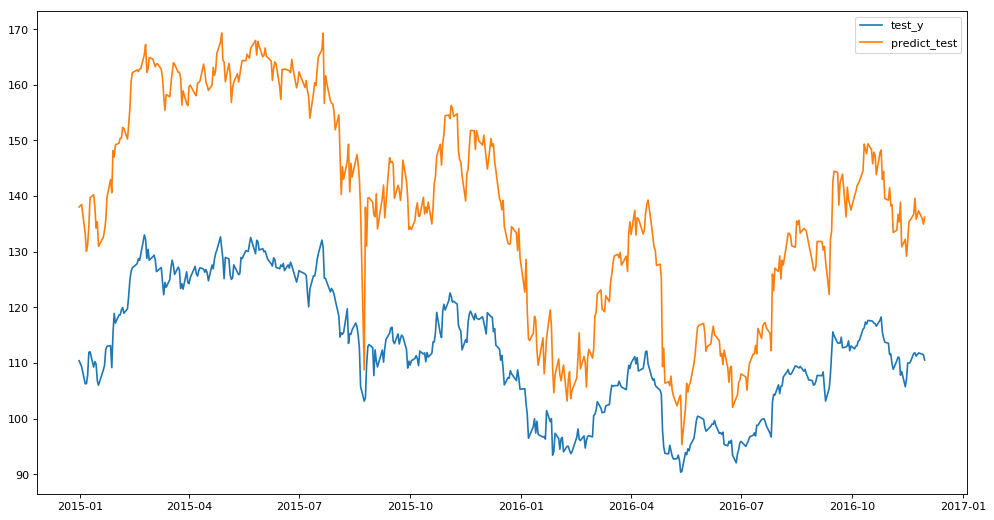

In [71]:
%matplotlib inline
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

index = pd.date_range(start = apple['Date'][0], end = apple['Date'][2033], freq = "D")
index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in apple['Date']]

# plt.plot(index[:2033] ,train_y, label='apple')
# plt.plot(index[:2033] ,predict_train, label='apple')
plt.plot(index[2033:] ,np.squeeze(test_y,axis=1), label='test_y')
plt.plot(index[2033:] ,np.squeeze(predict,axis=1), label='predict_test')
# plt.plot(index ,apple['compound'], label='compound')
plt.legend()
_ = plt.ylim()

Score of the model using the relative error

In [72]:
(abs(np.squeeze(test_y,axis=1)-np.squeeze(predict,axis=1))/np.squeeze(test_y,axis=1)).sum()

109.65919234878831

Prediction of the model on the training data to see that if its overfitting or not.

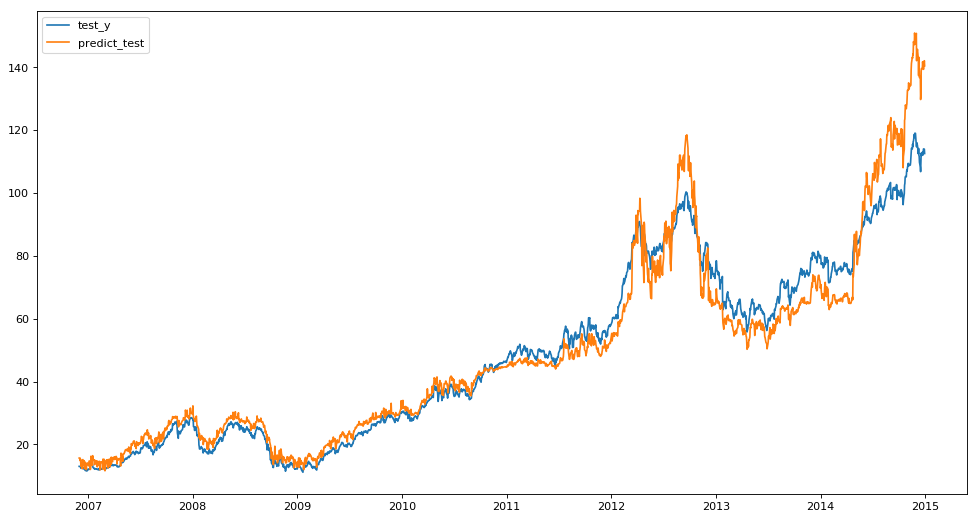

In [73]:
%matplotlib inline
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

index = pd.date_range(start = apple['Date'][0], end = apple['Date'][2033], freq = "D")
index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in apple['Date']]

# plt.plot(index[:2033] ,train_y, label='apple')
# plt.plot(index[:2033] ,predict_train, label='apple')
plt.plot(index[:2033] ,np.squeeze(train_y,axis=1), label='test_y')
plt.plot(index[:2033] ,np.squeeze(model.predict(train_x),axis=1), label='predict_test')
# plt.plot(index ,apple['compound'], label='compound')
plt.legend()
_ = plt.ylim()

## Refined Model (Final)

In [37]:
# make model
model=Sequential()

# layer 1
model.add(LSTM(128,input_shape=(1,train_x.shape[2:][0]),activation='relu', return_sequences=True ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 2
model.add(LSTM(128, return_sequences=True ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 3
model.add(LSTM(128, activation='relu',return_sequences=False ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 4
model.add(Dense(200,activation='relu' ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 5
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 6
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# final output in 1
model.add(Dense(1))

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 128)            69120     
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 1, 128)            512       
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
_________________________________________________________________
dense_9 (Dense)              (None, 100)               12900     
__________

#### Oprimise the model

In [82]:
# make optimiser
# opt=tf.keras.optimizers.Adam(lr=0.001, decay=1e-5)
# opt=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)
# opt=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0)
opt=keras.optimizers.RMSprop(lr=0.0005,rho=0.9, decay=0.0)
# compile the model
model.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])

# log file for tensorboard
time=datetime.now()
tbCallBack = keras.callbacks.TensorBoard(log_dir='/log/apple'+str(time), write_graph=True)

# for model checkpoint
filepath="Weights/apple_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint,tbCallBack]

## Simple training of final model

In [26]:
model.fit(
        train_x
        ,train_y
        , epochs=80
        ,batch_size=50
        ,verbose=1
        ,validation_split=0.1 
        ,callbacks=callbacks_list
        )

Train on 1829 samples, validate on 204 samples
Epoch 1/80
1829/1829 [==============================] - 4s 2ms/step - loss: 2350.2318 - acc: 0.0000e+00 - val_loss: 9261.6816 - val_acc: 0.0000e+00
Epoch 2/80
1829/1829 [==============================] - 1s 605us/step - loss: 2194.4051 - acc: 0.0000e+00 - val_loss: 9211.7999 - val_acc: 0.0000e+00
Epoch 3/80
1829/1829 [==============================] - 1s 623us/step - loss: 2110.7846 - acc: 0.0000e+00 - val_loss: 9349.3250 - val_acc: 0.0000e+00
Epoch 4/80
1829/1829 [==============================] - 1s 700us/step - loss: 2045.4387 - acc: 0.0000e+00 - val_loss: 9585.2504 - val_acc: 0.0000e+00
Epoch 5/80
1829/1829 [==============================] - 2s 1ms/step - loss: 1987.6418 - acc: 0.0000e+00 - val_loss: 9485.9159 - val_acc: 0.0000e+00
Epoch 6/80
1829/1829 [==============================] - 1s 785us/step - loss: 1932.7682 - acc: 0.0000e+00 - val_loss: 9331.9476 - val_acc: 0.0000e+00
Epoch 7/80
1829/1829 [==============================] - 2

Epoch 26/80
1829/1829 [==============================] - 1s 541us/step - loss: 811.4731 - acc: 0.0000e+00 - val_loss: 311.5329 - val_acc: 0.0000e+00
Epoch 27/80
1829/1829 [==============================] - 1s 509us/step - loss: 757.0275 - acc: 0.0000e+00 - val_loss: 352.1571 - val_acc: 0.0000e+00
Epoch 28/80
1829/1829 [==============================] - 1s 598us/step - loss: 705.2590 - acc: 0.0000e+00 - val_loss: 359.6793 - val_acc: 0.0000e+00
Epoch 29/80
1829/1829 [==============================] - 1s 611us/step - loss: 650.5073 - acc: 0.0000e+00 - val_loss: 317.7463 - val_acc: 0.0000e+00
Epoch 30/80
1829/1829 [==============================] - 1s 656us/step - loss: 595.0868 - acc: 0.0000e+00 - val_loss: 210.8392 - val_acc: 0.0000e+00
Epoch 31/80
1829/1829 [==============================] - 1s 570us/step - loss: 541.3621 - acc: 0.0000e+00 - val_loss: 159.9497 - val_acc: 0.0000e+00
Epoch 32/80
1829/1829 [==============================] - 1s 587us/step - loss: 492.1579 - acc: 0.0000e+00 

1829/1829 [==============================] - 1s 640us/step - loss: 37.1208 - acc: 0.0011 - val_loss: 89.3768 - val_acc: 0.0000e+00
Epoch 54/80
1829/1829 [==============================] - 1s 590us/step - loss: 37.1687 - acc: 0.0000e+00 - val_loss: 105.0310 - val_acc: 0.0000e+00
Epoch 55/80
1829/1829 [==============================] - 1s 691us/step - loss: 39.6945 - acc: 0.0000e+00 - val_loss: 107.0806 - val_acc: 0.0000e+00
Epoch 56/80
1829/1829 [==============================] - 2s 861us/step - loss: 30.2331 - acc: 0.0000e+00 - val_loss: 85.5672 - val_acc: 0.0000e+00
Epoch 57/80
1829/1829 [==============================] - 1s 682us/step - loss: 32.9021 - acc: 0.0000e+00 - val_loss: 128.5946 - val_acc: 0.0000e+00
Epoch 58/80
1829/1829 [==============================] - 1s 658us/step - loss: 35.1213 - acc: 0.0000e+00 - val_loss: 145.5519 - val_acc: 0.0000e+00
Epoch 59/80
1829/1829 [==============================] - 1s 548us/step - loss: 32.7104 - acc: 0.0000e+00 - val_loss: 106.2000 - va

#### test the model

In [27]:
predict=model.predict(test_x)

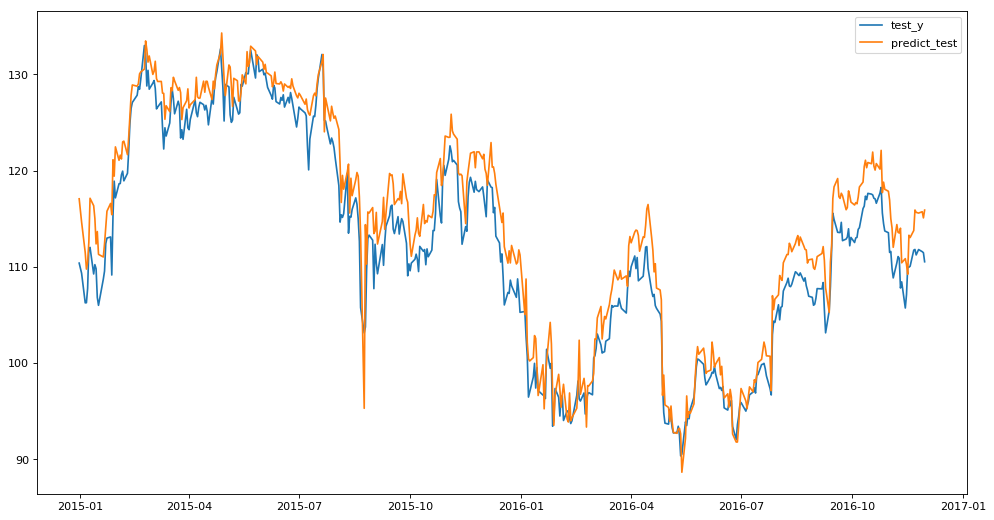

In [35]:
%matplotlib inline
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

index = pd.date_range(start = apple['Date'][0], end = apple['Date'][2033], freq = "D")
index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in apple['Date']]

# plt.plot(index[:2033] ,train_y, label='apple')
# plt.plot(index[:2033] ,predict_train, label='apple')
plt.plot(index[2033:] ,np.squeeze(test_y,axis=1), label='test_y')
plt.plot(index[2033:] ,np.squeeze(predict,axis=1), label='predict_test')
# plt.plot(index ,apple['compound'], label='compound')
plt.legend()
_ = plt.ylim()

#### Score of the model

In [36]:
(abs(np.squeeze(test_y,axis=1)-np.squeeze(predict,axis=1))/np.squeeze(test_y,axis=1)).sum()

11.5601864683916

predictions on the training data

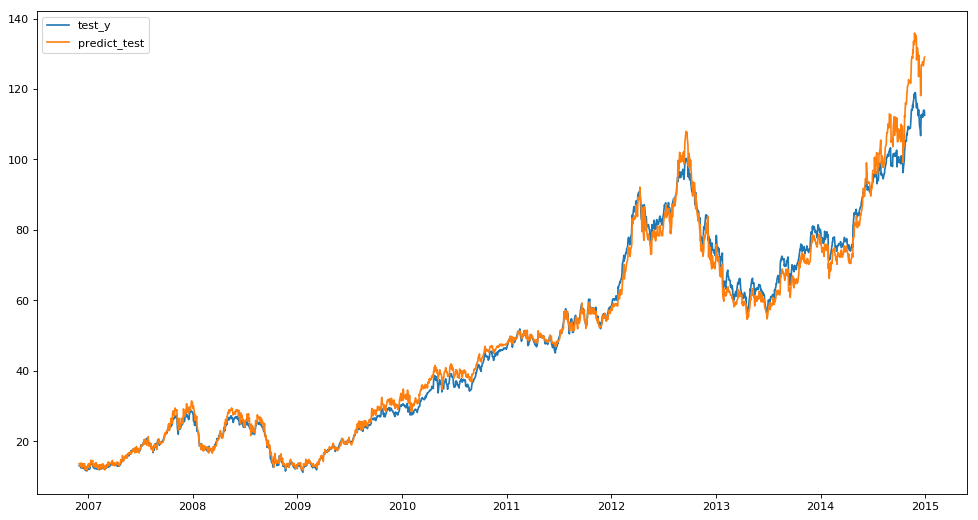

In [30]:
%matplotlib inline
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

index = pd.date_range(start = apple['Date'][0], end = apple['Date'][2033], freq = "D")
index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in apple['Date']]

# plt.plot(index[:2033] ,train_y, label='apple')
# plt.plot(index[:2033] ,predict_train, label='apple')
plt.plot(index[:2033] ,np.squeeze(train_y,axis=1), label='test_y')
plt.plot(index[:2033] ,np.squeeze(model.predict(train_x),axis=1), label='predict_test')
# plt.plot(index ,apple['compound'], label='compound')
plt.legend()
_ = plt.ylim()

## Framed Training

Compile the model

In [76]:
# make optimiser
# opt=tf.keras.optimizers.Adam(lr=0.001, decay=1e-5)
# opt=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)
# opt=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0)
opt=keras.optimizers.RMSprop(lr=0.0005,rho=0.9, decay=0.0)
# compile the model
model.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])

# log file for tensorboard
time=datetime.now()
tbCallBack = keras.callbacks.TensorBoard(log_dir='/log/apple_framed_'+str(time), write_graph=True)

# for model checkpoint
filepath="Weights/apple_weights_framed.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint,tbCallBack]

#### train using data frames

In [77]:
l=len(train_x)
frame=int(l*0.40)
shift=int(l*.10)
start=0
brake=False
end_frame=False
step=0
while brake==False:
    if start+frame<l:
        step+=1
        print(step,'  :::::::::::::::::::::::::::::::::::::::::::::')
        X=train_x[start:start+frame]
        Y=train_y[start:start+frame]
        model.fit(
                    X
                    ,Y
                    , epochs=30
                    ,batch_size=50
                    ,verbose=1
                    ,validation_split=0.1 
                    ,callbacks=callbacks_list
                    )
        start=start+shift
    else:
        if end_frame==True:
            step+=1
            print(step,start,'end train  :::::::::::::::::::::::::::::::::::::::::::::')
            X=train_x[start:]
            Y=train_y[start:]
            if len(X)>0:
                model.fit(
                        X
                        ,Y
                        , epochs=20
                        ,batch_size=50
                        ,verbose=1
                        ,validation_split=0.1 
                        ,callbacks=callbacks_list
                        )
            brake=True
        else:
            step+=1
            print(step,start,'end frame  :::::::::::::::::::::::::::::::::::::::::::::')
            X=train_x[start:]
            Y=train_y[start:]
            if len(X)>0:
                model.fit(
                        X
                        ,Y
                        , epochs=30
                        ,batch_size=50
                        ,verbose=1
                        ,validation_split=0.1 
                        ,callbacks=callbacks_list
                        )
            start=start+shift
            end_frame=True

1   :::::::::::::::::::::::::::::::::::::::::::::
Train on 731 samples, validate on 82 samples
Epoch 1/30
731/731 [==============================] - 10s 14ms/step - loss: 390.9046 - acc: 0.0000e+00 - val_loss: 818.6294 - val_acc: 0.0000e+00
Epoch 2/30
731/731 [==============================] - 1s 957us/step - loss: 386.1824 - acc: 0.0000e+00 - val_loss: 815.4117 - val_acc: 0.0000e+00
Epoch 3/30
731/731 [==============================] - 1s 918us/step - loss: 382.6256 - acc: 0.0000e+00 - val_loss: 810.0976 - val_acc: 0.0000e+00
Epoch 4/30
731/731 [==============================] - 1s 1000us/step - loss: 379.1143 - acc: 0.0000e+00 - val_loss: 808.2422 - val_acc: 0.0000e+00
Epoch 5/30
731/731 [==============================] - 1s 920us/step - loss: 376.2118 - acc: 0.0000e+00 - val_loss: 803.6906 - val_acc: 0.0000e+00
Epoch 6/30
731/731 [==============================] - 1s 929us/step - loss: 370.1427 - acc: 0.0000e+00 - val_loss: 803.2718 - val_acc: 0.0000e+00
Epoch 7/30
731/731 [========

731/731 [==============================] - 1s 884us/step - loss: 252.6188 - acc: 0.0000e+00 - val_loss: 620.5934 - val_acc: 0.0000e+00
Epoch 26/30
731/731 [==============================] - 1s 897us/step - loss: 246.1561 - acc: 0.0000e+00 - val_loss: 605.1988 - val_acc: 0.0000e+00
Epoch 27/30
731/731 [==============================] - 1s 887us/step - loss: 239.2795 - acc: 0.0000e+00 - val_loss: 592.5523 - val_acc: 0.0000e+00
Epoch 28/30
731/731 [==============================] - 1s 894us/step - loss: 232.3121 - acc: 0.0000e+00 - val_loss: 579.8676 - val_acc: 0.0000e+00
Epoch 29/30
731/731 [==============================] - 1s 833us/step - loss: 226.1056 - acc: 0.0000e+00 - val_loss: 560.1244 - val_acc: 0.0000e+00
Epoch 30/30
731/731 [==============================] - 1s 829us/step - loss: 219.0390 - acc: 0.0000e+00 - val_loss: 536.8798 - val_acc: 0.0000e+00
2   :::::::::::::::::::::::::::::::::::::::::::::
Train on 731 samples, validate on 82 samples
Epoch 1/30
731/731 [===============

Epoch 23/30
731/731 [==============================] - 1s 1ms/step - loss: 165.0601 - acc: 0.0000e+00 - val_loss: 250.7219 - val_acc: 0.0000e+00
Epoch 24/30
731/731 [==============================] - 1s 1ms/step - loss: 155.9914 - acc: 0.0000e+00 - val_loss: 192.2015 - val_acc: 0.0000e+00
Epoch 25/30
731/731 [==============================] - 1s 743us/step - loss: 147.2429 - acc: 0.0000e+00 - val_loss: 206.8883 - val_acc: 0.0000e+00
Epoch 26/30
731/731 [==============================] - 1s 909us/step - loss: 139.3586 - acc: 0.0000e+00 - val_loss: 116.1482 - val_acc: 0.0000e+00
Epoch 27/30
731/731 [==============================] - 1s 979us/step - loss: 130.4768 - acc: 0.0000e+00 - val_loss: 125.8799 - val_acc: 0.0000e+00
Epoch 28/30
731/731 [==============================] - 1s 800us/step - loss: 121.4503 - acc: 0.0000e+00 - val_loss: 137.9328 - val_acc: 0.0000e+00
Epoch 29/30
731/731 [==============================] - 1s 1ms/step - loss: 112.8719 - acc: 0.0000e+00 - val_loss: 164.9424

Epoch 22/30
731/731 [==============================] - 0s 534us/step - loss: 51.2582 - acc: 0.0000e+00 - val_loss: 87.6819 - val_acc: 0.0000e+00
Epoch 23/30
731/731 [==============================] - 0s 647us/step - loss: 46.8448 - acc: 0.0000e+00 - val_loss: 70.6546 - val_acc: 0.0000e+00
Epoch 24/30
731/731 [==============================] - 0s 627us/step - loss: 41.2188 - acc: 0.0000e+00 - val_loss: 63.6994 - val_acc: 0.0000e+00
Epoch 25/30
731/731 [==============================] - 0s 565us/step - loss: 37.8239 - acc: 0.0000e+00 - val_loss: 52.6828 - val_acc: 0.0000e+00
Epoch 26/30
731/731 [==============================] - 1s 717us/step - loss: 30.1700 - acc: 0.0000e+00 - val_loss: 73.9966 - val_acc: 0.0000e+00
Epoch 27/30
731/731 [==============================] - 0s 595us/step - loss: 25.7244 - acc: 0.0000e+00 - val_loss: 42.1663 - val_acc: 0.0000e+00
Epoch 28/30
731/731 [==============================] - 1s 876us/step - loss: 26.4614 - acc: 0.0000e+00 - val_loss: 45.1082 - val_a

731/731 [==============================] - 1s 950us/step - loss: 32.4822 - acc: 0.0000e+00 - val_loss: 57.8993 - val_acc: 0.0000e+00
Epoch 22/30
731/731 [==============================] - 1s 845us/step - loss: 27.5016 - acc: 0.0000e+00 - val_loss: 53.3465 - val_acc: 0.0000e+00
Epoch 23/30
731/731 [==============================] - 1s 821us/step - loss: 22.9129 - acc: 0.0000e+00 - val_loss: 48.4537 - val_acc: 0.0000e+00
Epoch 24/30
731/731 [==============================] - 1s 1ms/step - loss: 25.6963 - acc: 0.0000e+00 - val_loss: 57.9637 - val_acc: 0.0000e+00
Epoch 25/30
731/731 [==============================] - 1s 1ms/step - loss: 23.7065 - acc: 0.0000e+00 - val_loss: 128.2050 - val_acc: 0.0000e+00
Epoch 26/30
731/731 [==============================] - 1s 869us/step - loss: 19.5454 - acc: 0.0000e+00 - val_loss: 80.0315 - val_acc: 0.0000e+00
Epoch 27/30
731/731 [==============================] - 1s 862us/step - loss: 21.4184 - acc: 0.0000e+00 - val_loss: 73.2027 - val_acc: 0.0000e+00


731/731 [==============================] - 0s 668us/step - loss: 39.9633 - acc: 0.0000e+00 - val_loss: 24.0879 - val_acc: 0.0000e+00
Epoch 22/30
731/731 [==============================] - 0s 632us/step - loss: 29.6125 - acc: 0.0000e+00 - val_loss: 15.5882 - val_acc: 0.0000e+00
Epoch 23/30
731/731 [==============================] - 0s 607us/step - loss: 31.6708 - acc: 0.0014 - val_loss: 24.4879 - val_acc: 0.0000e+00
Epoch 24/30
731/731 [==============================] - 0s 628us/step - loss: 31.2661 - acc: 0.0014 - val_loss: 11.3712 - val_acc: 0.0000e+00
Epoch 25/30
731/731 [==============================] - 1s 816us/step - loss: 25.9087 - acc: 0.0000e+00 - val_loss: 9.3590 - val_acc: 0.0000e+00
Epoch 26/30
731/731 [==============================] - 1s 844us/step - loss: 26.5635 - acc: 0.0000e+00 - val_loss: 6.0117 - val_acc: 0.0000e+00
Epoch 27/30
731/731 [==============================] - 1s 836us/step - loss: 23.7056 - acc: 0.0000e+00 - val_loss: 4.0548 - val_acc: 0.0000e+00
Epoch 28

731/731 [==============================] - 1s 734us/step - loss: 17.9761 - acc: 0.0000e+00 - val_loss: 3.5684 - val_acc: 0.0000e+00
Epoch 21/30
731/731 [==============================] - 0s 668us/step - loss: 21.8941 - acc: 0.0000e+00 - val_loss: 12.4147 - val_acc: 0.0000e+00
Epoch 22/30
731/731 [==============================] - 0s 626us/step - loss: 19.0167 - acc: 0.0000e+00 - val_loss: 3.3802 - val_acc: 0.0000e+00
Epoch 23/30
731/731 [==============================] - 1s 720us/step - loss: 18.2590 - acc: 0.0000e+00 - val_loss: 7.1764 - val_acc: 0.0000e+00
Epoch 24/30
731/731 [==============================] - 1s 733us/step - loss: 23.1034 - acc: 0.0000e+00 - val_loss: 10.9881 - val_acc: 0.0000e+00
Epoch 25/30
731/731 [==============================] - 0s 621us/step - loss: 18.9104 - acc: 0.0000e+00 - val_loss: 3.2594 - val_acc: 0.0000e+00
Epoch 26/30
731/731 [==============================] - 1s 788us/step - loss: 19.7565 - acc: 0.0000e+00 - val_loss: 3.0098 - val_acc: 0.0000e+00
Ep

Epoch 21/30
731/731 [==============================] - 1s 762us/step - loss: 13.9549 - acc: 0.0014 - val_loss: 26.2189 - val_acc: 0.0000e+00
Epoch 22/30
731/731 [==============================] - 0s 615us/step - loss: 16.3936 - acc: 0.0000e+00 - val_loss: 14.2415 - val_acc: 0.0000e+00
Epoch 23/30
731/731 [==============================] - 0s 649us/step - loss: 19.8260 - acc: 0.0000e+00 - val_loss: 27.2162 - val_acc: 0.0000e+00
Epoch 24/30
731/731 [==============================] - 1s 1ms/step - loss: 15.8429 - acc: 0.0000e+00 - val_loss: 20.4227 - val_acc: 0.0000e+00
Epoch 25/30
731/731 [==============================] - 1s 854us/step - loss: 18.3181 - acc: 0.0000e+00 - val_loss: 16.8559 - val_acc: 0.0000e+00
Epoch 26/30
731/731 [==============================] - 0s 671us/step - loss: 16.6844 - acc: 0.0000e+00 - val_loss: 80.2272 - val_acc: 0.0000e+00
Epoch 27/30
731/731 [==============================] - 0s 602us/step - loss: 16.0508 - acc: 0.0014 - val_loss: 74.4581 - val_acc: 0.0000

Epoch 22/30
550/550 [==============================] - 0s 651us/step - loss: 15.7270 - acc: 0.0000e+00 - val_loss: 2.4974 - val_acc: 0.0484
Epoch 23/30
550/550 [==============================] - 0s 617us/step - loss: 12.9378 - acc: 0.0000e+00 - val_loss: 3.2600 - val_acc: 0.0000e+00
Epoch 24/30
550/550 [==============================] - 0s 596us/step - loss: 13.7578 - acc: 0.0018 - val_loss: 3.1686 - val_acc: 0.0161
Epoch 25/30
550/550 [==============================] - 0s 634us/step - loss: 16.0027 - acc: 0.0018 - val_loss: 6.6298 - val_acc: 0.0000e+00
Epoch 26/30
550/550 [==============================] - 0s 648us/step - loss: 14.3633 - acc: 0.0018 - val_loss: 4.8445 - val_acc: 0.0161
Epoch 27/30
550/550 [==============================] - 0s 677us/step - loss: 14.8882 - acc: 0.0000e+00 - val_loss: 2.6404 - val_acc: 0.0323
Epoch 28/30
550/550 [==============================] - 0s 617us/step - loss: 12.6010 - acc: 0.0018 - val_loss: 4.1145 - val_acc: 0.0161
Epoch 29/30
550/550 [=======

#### test the model

In [78]:
predict=model.predict(test_x)

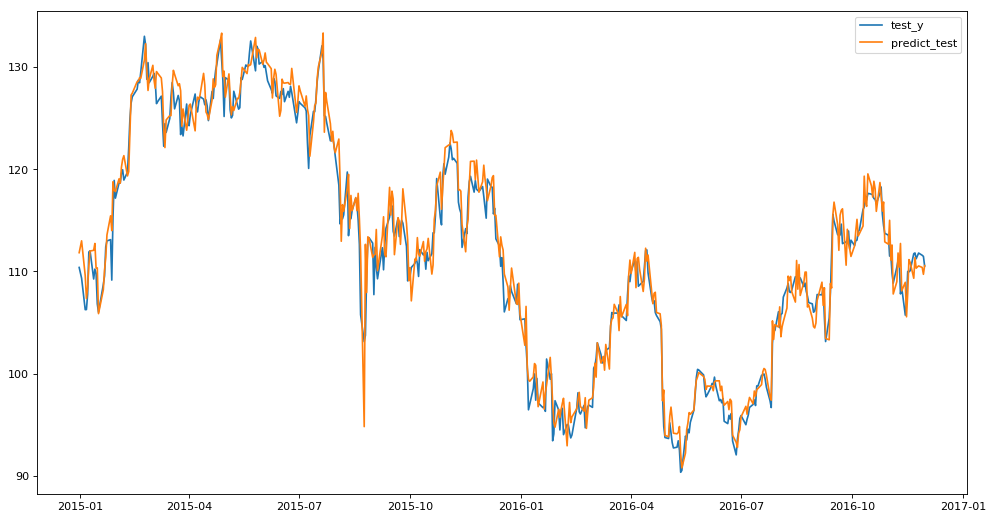

In [79]:
%matplotlib inline
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

index = pd.date_range(start = apple['Date'][0], end = apple['Date'][2033], freq = "D")
index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in apple['Date']]

# plt.plot(index[:2033] ,train_y, label='apple')
# plt.plot(index[:2033] ,predict_train, label='apple')
plt.plot(index[2033:] ,np.squeeze(test_y,axis=1), label='test_y')
plt.plot(index[2033:] ,np.squeeze(predict,axis=1), label='predict_test')
# plt.plot(index ,apple['compound'], label='compound')
plt.legend()
_ = plt.ylim()

### Finla Score of the model

In [80]:
(abs(np.squeeze(test_y,axis=1)-np.squeeze(predict,axis=1))/np.squeeze(test_y,axis=1)).sum()

6.156167407969124

Predictions on the training data

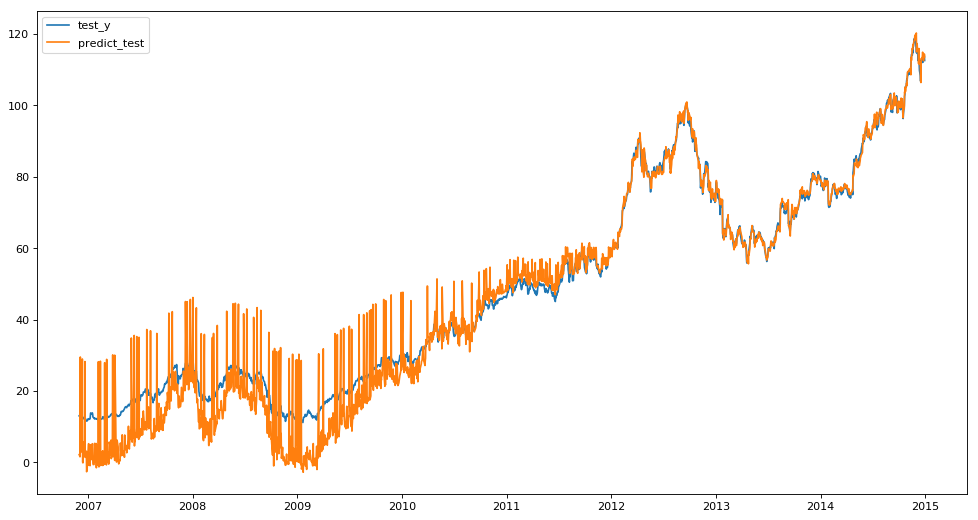

In [81]:
%matplotlib inline
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

index = pd.date_range(start = apple['Date'][0], end = apple['Date'][2033], freq = "D")
index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in apple['Date']]

# plt.plot(index[:2033] ,train_y, label='apple')
# plt.plot(index[:2033] ,predict_train, label='apple')
plt.plot(index[:2033] ,np.squeeze(train_y,axis=1), label='test_y')
plt.plot(index[:2033] ,np.squeeze(model.predict(train_x),axis=1), label='predict_test')
# plt.plot(index ,apple['compound'], label='compound')
plt.legend()
_ = plt.ylim()